<center>

### COSC2753 - Machine Learning

# **Recommend System**

<center>────────────────────────────</center>
&nbsp;

# I. Introduction

In this notebook, we will develop a recommendation system which is capable of recommending 10 furniture images in the dataset which is similar to the input furniture image from users. This process will involve the following steps:

- **Image classification:** Using our previous selected model to classify the input furniture image provided from users into one of 6 categories.
- 

In [14]:
%pip uninstall matplotlib
%pip install matplotlib

^C
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [11]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [1]:
import tensorflow as tf

print("TF version:", tf.__version__)
print(
    "GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE"
)

TF version: 2.10.1
GPU is available


# II. Importing Libraries

In [3]:
# # Import necessary packages
import pandas as pd  # Data manipulation
import sys  # System specific parameters and functions
import importlib  # Importing modules
import tensorflow as tf  # Machine learning
from sklearn.model_selection import train_test_split  # Split for train and test
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Image data generator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report  # Metrics
from sklearn.utils.class_weight import compute_class_weight  # Class weights
import numpy as np
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

# Reload modules
sys.path.append("../../")  # Root directory
modules_to_reload = ["scripts.leon", "scripts.styler"]

# Reload modules if they have been modified
missing_modules = []

for module_name in modules_to_reload:
    if module_name in sys.modules:
        importlib.reload(sys.modules[module_name])
    else:
        missing_modules.append(module_name)

# Recache missing modules
if missing_modules:
    print(f"Modules {missing_modules} not found. Recaching...")

# Import user-defined scripts
from scripts.leon import Leon  # Leon class
from scripts.styler import Styler  # Styler class

# # Configuration
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.precision", 3)

# Initialize objects
leon = Leon()
styler = Styler()

Modules ['scripts.leon', 'scripts.styler'] not found. Recaching...

        @|\@@
       -  @@@@                                                            LEON 1.0.0
      /7   @@@@                                         This is Leon, the friendly lion. He is here to help you
     /    @@@@@@                                     Leon is tailored to manipulate images, data and visualizations
     \-' @@@@@@@@`-_______________                                      Made by: Team X
      -@@@@@@@@@             /    \                                     Version: 1.0.3
 _______/    /_       ______/      |__________-
/,__________/  `-.___/,_____________----------_)



# III. Load database for recommendation system

The recommendation system will only contain the raw image files, not including any augment data and duplicated data.

In [21]:
df_train = pd.read_csv("../../data/processed/train.csv",delimiter=',')
df_test = pd.read_csv("../../data/test/test.csv",delimiter=',')
if 'Path' in df_train.columns and 'Path' in df_test.columns:
    # Concatenate the dataframes vertically
    combined_df = pd.concat([df_train, df_test], ignore_index=True)

    # Filter the combined dataframe to exclude rows where the 'Path' column contains "aug_"
    filtered_df = combined_df[~combined_df['Path'].str.contains('aug_')]

In [22]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81935 entries, 0 to 213018
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Path      81935 non-null  object 
 1   Category  81935 non-null  object 
 2   Style     81935 non-null  object 
 3   Width     81935 non-null  int64  
 4   Height    81935 non-null  int64  
 5   MinValue  81935 non-null  int64  
 6   MaxValue  81935 non-null  int64  
 7   StdDev    81935 non-null  float64
dtypes: float64(1), int64(4), object(3)
memory usage: 5.6+ MB


There are 81935 images in the raw dataset. excluding any duplicated data and augmentation.

# IV. Feature Extraction

In this part, we will build a Convolutional Neural Network (CNN) to extract feature vectors from images.

In [23]:
INPUT_DIM = (256,256, 3)
FEATURE_VECTOR_DIM = 16

In [24]:
feat_extractor = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (4, 4), activation='relu', input_shape=INPUT_DIM),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (4, 4), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (4, 4), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(FEATURE_VECTOR_DIM, activation='relu')
])

feat_extractor.compile(optimizer='adam', loss='mse')

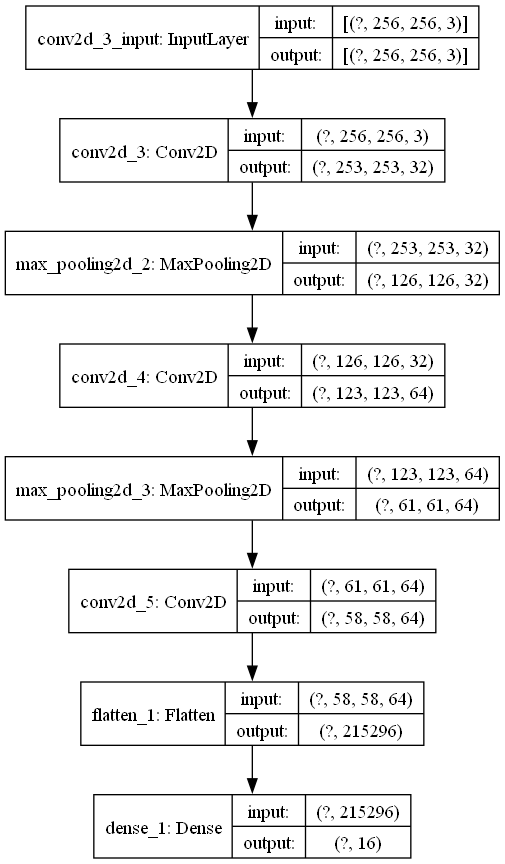

In [25]:
tf.keras.utils.plot_model(feat_extractor, show_shapes=True)

In [26]:
feat_extractor.save("feature_extract.keras", overwrite=True)

In [27]:
recommendation = {'Path': [], 'Category': []}
for i in range(FEATURE_VECTOR_DIM):
    recommendation[f'Feature {i}'] = []

In [28]:
# from tqdm.auto import tqdm
# from PIL import Image
# import numpy as np
# import tensorflow as tf

# recommendation = {'Path': [], 'Category': []}
# for i in range(FEATURE_VECTOR_DIM):
#     recommendation[f'Feature {i}'] = []
# with tqdm(total=len(filtered_df), desc='Extracting feature vectors from raw database', position=0, leave=True) as pbar:
#     for i, row in filtered_df.iterrows():
#         pbar.update()
#         recommendation['Path'].append(row['Path'])
#         recommendation['Category'].append(row['Category'])
#         with Image.open(row['Path']) as ref:  # Open the image from the row
#             ref = ref.resize((256, 256))  # Resize the image if needed
#             ref_array = np.array(ref)  # Convert PIL image to NumPy array
#             ref_array = ref_array / 255.0  # Normalize pixel values to [0, 1]
#             ref_tensor = tf.convert_to_tensor(ref_array, dtype=tf.float32)  # Convert NumPy array to TensorFlow tensor
#             ref_tensor = tf.expand_dims(ref_tensor, axis=0)  # Add batch dimension

#             ref_feature_vector = feat_extractor.predict(ref_tensor, verbose=0)
#             for j, feature in enumerate(ref_feature_vector.reshape(-1)):
#                 recommendation[f'Feature {j}'].append(feature)

    


In [29]:
## Covert to dataframe
# print("Length of 'Path':", len(recommendation['Path']))
# print("Length of 'Category':", len(recommendation['Category']))
# for key, value in recommendation.items():
#     if key.startswith('Feature'):
#         print(f"Length of {key}: {len(value)}")

# recommendation_df = pd.DataFrame(recommendation)

In [30]:
recommendation_df = pd.read_csv("../../data/feature_vectors.csv",delimiter=',')
recommendation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81935 entries, 0 to 81934
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Path        81935 non-null  object 
 1   Category    81935 non-null  object 
 2   Feature 0   81935 non-null  float64
 3   Feature 1   81935 non-null  float64
 4   Feature 2   81935 non-null  float64
 5   Feature 3   81935 non-null  float64
 6   Feature 4   81935 non-null  float64
 7   Feature 5   81935 non-null  float64
 8   Feature 6   81935 non-null  float64
 9   Feature 7   81935 non-null  float64
 10  Feature 8   81935 non-null  float64
 11  Feature 9   81935 non-null  float64
 12  Feature 10  81935 non-null  float64
 13  Feature 11  81935 non-null  float64
 14  Feature 12  81935 non-null  float64
 15  Feature 13  81935 non-null  float64
 16  Feature 14  81935 non-null  float64
 17  Feature 15  81935 non-null  float64
dtypes: float64(16), object(2)
memory usage: 11.3+ MB


In [31]:
from sklearn.cluster import KMeans

In [32]:
import joblib
clu = KMeans(init='k-means++', n_init=1)
joblib.dump(clu, "cluster")

['cluster']

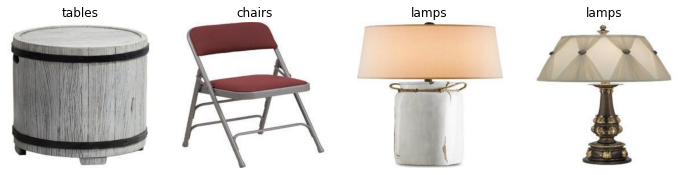

In [33]:
from PIL import Image
# Sample 4 random images from filtered_df
random_img = filtered_df.sample(4)

# Create subplots
fig, ax = plt.subplots(1, 4, figsize=(12, 4))

# Iterate over each randomly selected image
for i, (index, row) in enumerate(random_img.iterrows()):
    # Load the image using PIL
    with Image.open(row['Path']) as img:
        # Display the image
        ax[i].imshow(img)
        ax[i].set_title(row['Category'], fontsize=12)  # Assuming 'Category' is the column containing image categories
        ax[i].axis('off')

# Show the plot
plt.show()

In [34]:
fe = tf.keras.models.load_model("feature_extract.keras")


In [35]:
import tensorflow as tf
from PIL import Image
import numpy as np

# Define constants
CLASS_LABELS = ["beds", "chairs", "dressers","sofas","lamps","tables"]  # Example class labels, replace with actual labels

def classify(image_path: str, classifier_path: str, verbose: bool = False, return_original: bool = True) -> tuple:
    """
    Uses a trained machine learning model to classify an image loaded from disk.

    :param image_path: Path to the image to be classified.
    :param classifier_path: Path to the classifier model to be used.
    :param verbose: Verbose output.
    :param return_original: Whether to return the original image or the processed image.
    :return: The original/processed image (PIL.image) and its classification (str).
    """
    
    # Load the image from the given path
    im_original = Image.open(image_path)
    
    # Resize the image to the target size
    im_processed = im_original.resize((256, 256))
    
    # Convert the PIL image to a NumPy array and normalize pixel values to [0, 1]
    im_array = np.array(im_processed) / 255.0
    
    # Convert the NumPy array to a TensorFlow tensor and add a batch dimension
    im_tensor = tf.convert_to_tensor(im_array, dtype=tf.float32)
    im_tensor = tf.expand_dims(im_tensor, axis=0)
    
    # Load the pre-trained classifier model
    model: tf.keras.Model = tf.keras.models.load_model(classifier_path)
    
    # Predict the class of the processed image
    pred = model.predict(im_tensor, verbose=1 if verbose else 0)
    
    # Get the index of the predicted class
    pred_class_idx = tf.argmax(pred, axis=1).numpy()[0]
    
    # Get the label of the predicted class
    pred_class_label = CLASS_LABELS[pred_class_idx]
    
    # Return the original or processed image along with the predicted class label
    if return_original:
        return im_original, pred_class_label
    else:
        return im_processed, pred_class_label


In [36]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd
from PIL import Image

num_recommendations = 4  # Will be provided by the user in the client code
k = int(np.sqrt(len(recommendation_df) / num_recommendations))

# Ensure `n_init` and other parameters are integers
# clu.set_params(n_clusters=k)  # Ensure n_init is set to an intege

cnn = tf.keras.models.load_model("./cache_cnn/cnn.h5")
cnn.summary()

ValueError: Unknown optimizer: Custom>Adam

In [ ]:
results = []

for ref_path in random_img['Path']:
    with Image.open(ref_path) as ref:
        ref_processed, ref_class = classify(f'{ref_path}', classifier_path='cache_cnn/cnn', return_original=False)
        recommendation = recommendation_df[recommendation_df['Category'] == ref_class]

        # Extract reference image feature vector
        ref_processed = np.squeeze(ref_processed)
        ref_feature_vector = fe.predict(
            tf.expand_dims(ref_processed, axis=0),
            verbose=0
        )
        ref_feature_vector = ref_feature_vector.astype(float)
        ref_feature_vector = ref_feature_vector.reshape(1, -1)

        # Cluster reference image
        clu.fit(recommendation.drop(['Path', 'Category'], axis='columns').values)
        ref_cluster = clu.predict(ref_feature_vector)
        ref_cluster_indices = np.where(clu.labels_ == ref_cluster)[0]
        recommendation = recommendation.iloc[ref_cluster_indices]

        # Rank cluster and produce top cosine similarity recommendations
        cosine_similarities = cosine_similarity(ref_feature_vector, recommendation.drop(['Path', 'Category'], axis='columns'))
        sorted_ref_cluster_indices = np.argsort(-cosine_similarities.flatten())  # Updated line
        top_ref_cluster_indices = sorted_ref_cluster_indices[:num_recommendations]
        recommendation = recommendation.iloc[top_ref_cluster_indices]

        results.append(recommendation['Path'].values)

print(results)


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `

c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[array(['..\\..\\data\\raw\\Furniture_Data\\Furniture_Data\\sofas\\Contemporary\\1137contemporary-sofas.jpg',
       '..\\..\\data\\raw\\Furniture_Data\\Furniture_Data\\sofas\\Contemporary\\2774contemporary-sofas.jpg',
       '..\\..\\data\\raw\\Furniture_Data\\Furniture_Data\\sofas\\Contemporary\\715contemporary-sofas.jpg',
       '..\\..\\data\\raw\\Furniture_Data\\Furniture_Data\\sofas\\Transitional\\29304transitional-loveseats.jpg'],
      dtype=object), array(['..\\..\\data\\raw\\Furniture_Data\\Furniture_Data\\chairs\\Midcentury\\17443midcentury-dining-chairs.jpg',
       '..\\..\\data\\raw\\Furniture_Data\\Furniture_Data\\chairs\\Transitional\\22786transitional-dining-chairs.jpg',
       '..\\..\\data\\raw\\Furniture_Data\\Furniture_Data\\chairs\\Midcentury\\20313midcentury-dining-chairs.jpg',
       '..\\..\\data\\raw\\Furniture_Data\\Furniture_Data\\chairs\\Contemporary\\364contemporary-dining-chairs.jpg'],
      dtype=object), array(['..\\..\\data\\raw\\Furniture_Data\\Furnit

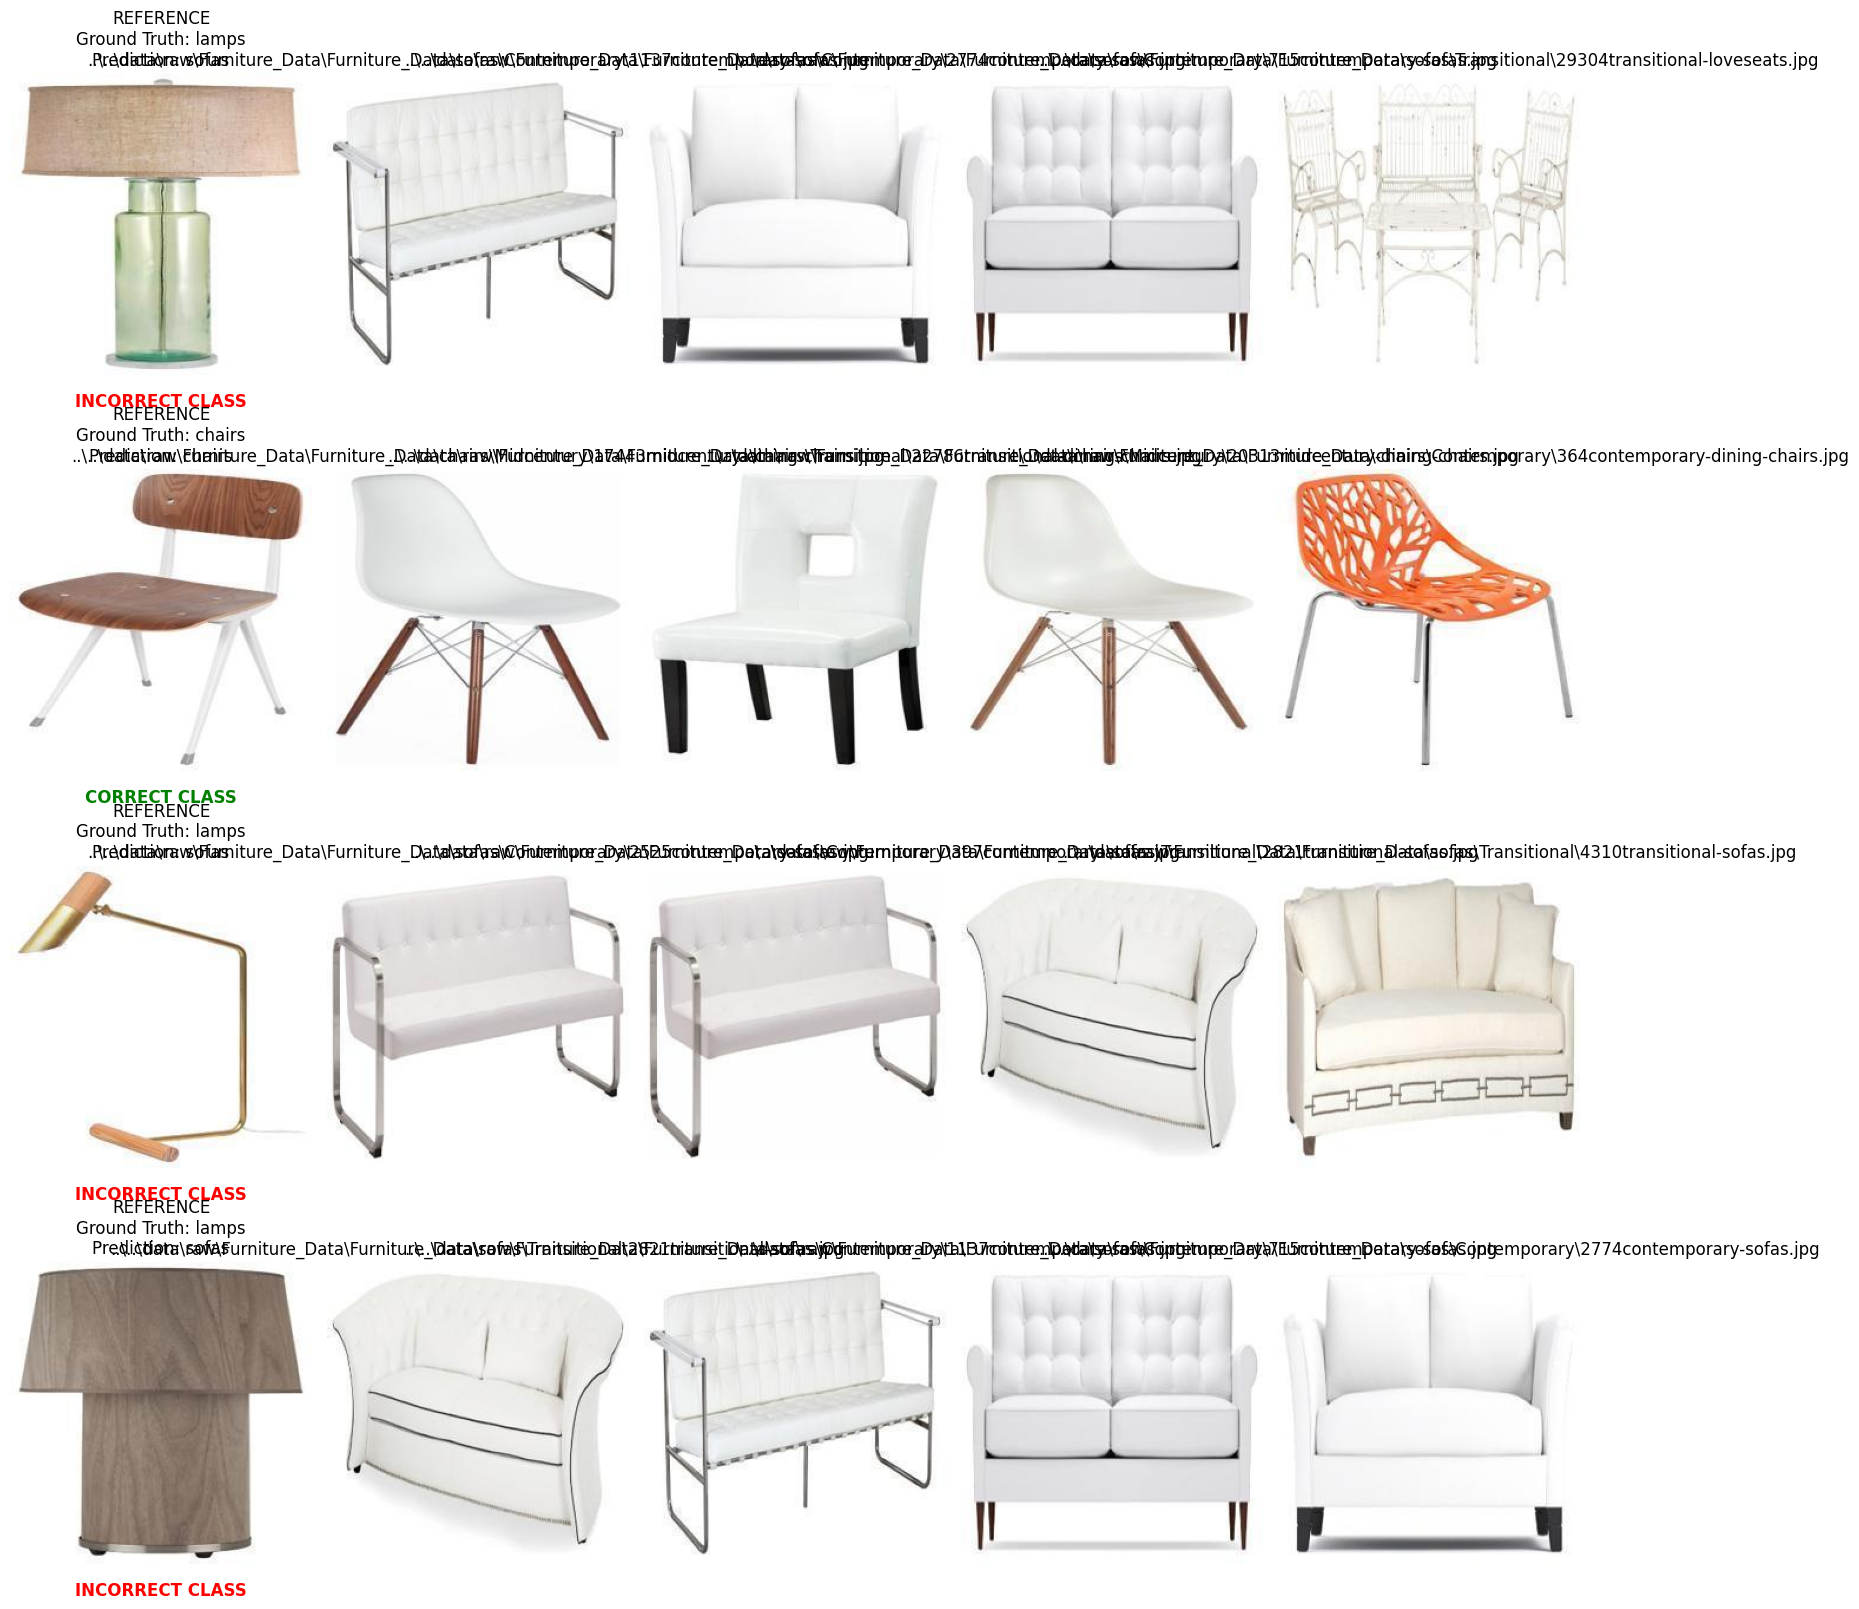

In [ ]:
fig, ax = plt.subplots(4, 5, figsize=(16, 16))
for i, ref_path in enumerate(random_img['Path']):
    with Image.open(f'{ref_path}') as ref:
        true_label = ref_path.split('\\')[-3]
        _, predicted_label = classify(f'{ref_path}', classifier_path='cache_cnn/cnn.h5')

        ax[i][0].imshow(ref)
        ax[i][0].set_title(
            f'REFERENCE\n'
            f'Ground Truth: {true_label}\n'
            f'Prediction: {predicted_label}',
            fontsize=12
        )
        ax[i][0].text(
            0.5, -0.08, f'{"CORRECT CLASS" if true_label == predicted_label else "INCORRECT CLASS"}',
            horizontalalignment='center',
            verticalalignment='center_baseline',
            transform=ax[i][0].transAxes,
            fontsize=12,
            color='green' if true_label == predicted_label else 'red',
            weight='bold'
        )
        ax[i][0].axis('off')

    for j, rec_path in enumerate(results[i], start=1):
        with Image.open(f'{rec_path}') as rec:
            ax[i][j].imshow(rec)
            ax[i][j].set_title(rec_path, fontsize=12)
            ax[i][j].axis('off')


plt.tight_layout()
plt.show()